# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [1]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


In [2]:
!{sys.executable} -m pip install tqdm


### Import Dependencies

# System libraries

In [3]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training


/group/cake/.venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
print(os.getcwd())

/group/cake/our-git-project/develop/ramona


### Initialize Environment

In [5]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder="/group/cake")
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /group/cake
 - Project folder: /group/cake/our-git-project
 - Datasets folder: /data/training
 - Models folder: /group/cake/our-git-project/models
 - Experiments folder: /group/cake/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [6]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (3.0, 3.0, 3.0)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
}


### Load Meta Data

In [7]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/data/training/A001_orig.nii.gz,/data/training/A001_masks.nii.gz,/data/training/A001_vessel.nii.gz,/data/training/A001_labeledMasks.nii.gz
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/data/training/A003_orig.nii.gz,/data/training/A003_masks.nii.gz,/data/training/A003_vessel.nii.gz,/data/training/A003_labeledMasks.nii.gz
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/data/training/A005_orig.nii.gz,/data/training/A005_masks.nii.gz,/data/training/A005_vessel.nii.gz,/data/training/A005_labeledMasks.nii.gz
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/data/training/A006_orig.nii.gz,/data/training/A006_masks.nii.gz,/data/training/A006_vessel.nii.gz,/data/training/A006_labeledMasks.nii.gz
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/data/training/A008_orig.nii.gz,/data/training/A008_masks.nii.gz,/data/training/A008_vessel.nii.gz,/data/training/A008_labeledMasks.nii.gz


### Load & Split MRI Data

In [12]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
#case_list = ["A001","A003","A005","A006","A008", "A010", "A012","A009"]
#df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

109
98
         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [13]:
from aneurysm_utils import preprocessing

preprocessing.check_mri_shapes(mri_imgs_train)

Most common:
(47, 47, 41):      75
(47, 47, 40):       5
(24, 24, 21):       5
(37, 37, 33):       2


## Transform & Preprocess Data

In [14]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...


In [15]:
size = (47, 47, 41)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))

Most common:
(47, 47, 41):      75
(array([0., 1.], dtype=float32), array([90565,     4]))


### Optional: View image


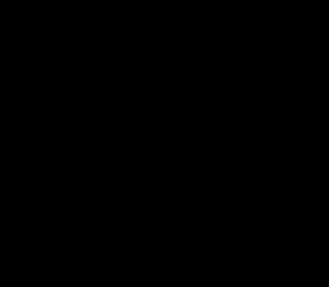
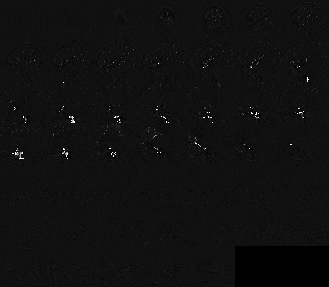

In [16]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [17]:
evaluation.plot_slices(mri_imgs_train[0])

0.0 1.0 None None


## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [20]:
artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    "batch_size": 3,
    "epochs": 100,
    "learning_rate": 1.0e-5, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.005, # 1e-3
    "model_name": 'SegNet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 1000.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": "ReduceLROnPlateau", # "ReduceLROnPlateau",
    "save_models": False,
    "debug": False,
}

params.update(dataset_params)
params.update(preprocessing_params)

# data augmentation

In [21]:
# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/83f6b7f60bb34d5f853b2871a88db438



[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-13-21-11-01_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 75
[INFO] Validation dataset loaded. Length: 9
[INFO] Engine run starting with max_epochs=100.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:52
[INFO] Learning rate: 1e-05
[INFO] Engine run complete. Time taken: 00:02:52
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.63
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1e-05
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.63
[INFO] Epoch[1] Complete. Time taken: 00:06:41
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning 

[INFO] Validation Results - Epoch: 16 Bal Avg accuracy: 0.96 Avg loss: 0.41
[INFO] Epoch[16] Complete. Time taken: 00:06:13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 5e-06
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 17 Bal Avg accuracy: 0.85 Avg loss: 1.41
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 5e-06
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 17 Bal Avg accuracy: 0.85 Avg loss: 6.96
[INFO] Epoch[17] Complete. Time taken: 00:06:13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 5e-06
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 18 Bal Avg accuracy: 0.82 Avg loss: 1.04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[

[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.25e-06
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 32 Bal Avg accuracy: 0.83 Avg loss: 0.63
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.25e-06
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 32 Bal Avg accuracy: 0.88 Avg loss: 0.47
[INFO] Epoch[32] Complete. Time taken: 00:06:13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.25e-06
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 33 Bal Avg accuracy: 0.83 Avg loss: 1.00
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.25e-06
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 3

[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.5625e-07
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 47 Bal Avg accuracy: 0.85 Avg loss: 3.98
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.5625e-07
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 47 Bal Avg accuracy: 0.90 Avg loss: 3.28
[INFO] Epoch[47] Complete. Time taken: 00:06:13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.5625e-07
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 48 Bal Avg accuracy: 0.84 Avg loss: 3.10
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.5625e-07
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 48 Bal Avg accuracy: 0.81 Avg loss: 3.7

[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 3.90625e-08
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 62 Bal Avg accuracy: 0.73 Avg loss: 2.02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 3.90625e-08
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 62 Bal Avg accuracy: 0.75 Avg loss: 2.20
[INFO] Epoch[62] Complete. Time taken: 00:06:13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 63 Bal Avg accuracy: 0.83 Avg loss: 2.21
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 63 Bal Avg accuracy: 0.80 Avg los

[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:54
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:02:54
[INFO] Training Results - Epoch: 77 Bal Avg accuracy: 0.83 Avg loss: 1.92
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 77 Bal Avg accuracy: 0.75 Avg loss: 1.60
[INFO] Epoch[77] Complete. Time taken: 00:06:14
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:54
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:02:54
[INFO] Training Results - Epoch: 78 Bal Avg accuracy: 0.81 Avg loss: 2.07
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Re

[INFO] Epoch[91] Complete. Time taken: 00:06:13
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 92 Bal Avg accuracy: 0.88 Avg loss: 3.18
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:00:21
[INFO] Validation Results - Epoch: 92 Bal Avg accuracy: 0.86 Avg loss: 4.20
[INFO] Epoch[92] Complete. Time taken: 00:06:12
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:02:53
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run complete. Time taken: 00:02:53
[INFO] Training Results - Epoch: 93 Bal Avg accuracy: 0.81 Avg loss: 2.48
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:21
[INFO] Learning rate: 1.953125e-08
[INFO] Engine run com

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/83f6b7f60bb34d5f853b2871a88db438
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [251]              : (0.27061665058135986, 0.7983548641204834)
COMET INFO:     train_accuracy [100]    : (0.27824128458119113, 0.9997883750401034)
COMET INFO:     train_avg_loss [100]    : (0.5084976042610303, 13.042733946898347)
COMET INFO:     train_bal_acc [100]     : (0.4517634249973538, 0.888258908897517)
COMET INFO:     train_curr_epoch [100]  : (1, 100)
COMET INFO:     train_sen [100]         : (0.0, 0.9637883008356546)
COMET INFO:     train_spec [100]        : (0.27814304895541125, 1.0)
COMET INFO:     validate_accuracy [100] : (0.18080887599617312, 0.9998133230824781)
COMET INFO:     validate_bal_acc [100]  : (0.41

TypeError: new(): invalid data type 'str'

## Evaluate Model

Do evaluation, e.g. visualizations  

In [ ]:
from aneurysm_utils.utils.pytorch_utils import predict

In [ ]:
model = exp.artifacts["model"]

In [ ]:
predictions = predict(model, mri_imgs_val,apply_softmax=False )

In [ ]:
predictions[0][1]

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)